In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# Load training data
training_data = pd.read_csv("/kaggle/input/titanic/train.csv")

# Load testing data
testing_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# Concatenate training and testing data to split it later
all_data = pd.concat([training_data, testing_data])

# Data exploration

In [3]:
# I think name prefix would be a feature
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check for nulls values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Check Ticket classes. It seems Ticket number is a kind of ID for tripulants. Due to unique tickets numbers against rows numbers, 
# i can say this ticket would be a kind of unique id.  
training_data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
349216      1
348124      1
A/5. 851    1
113796      1
PC 17599    1
Name: Ticket, Length: 681, dtype: int64

In [6]:
# Check how many numeric ticked number exists. This would be a new feature, because is the best way to use Ticket column.
training_data[training_data["Ticket"].str.isnumeric() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
# Check Cabins per tripulant but this feature wont be used due to huge amount of NaN values
training_data["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E63            1
D47            1
D56            1
C101           1
C70            1
Name: Cabin, Length: 147, dtype: int64

In [8]:
# Print count of dead people depending on specific classes

print(pd.pivot_table(training_data, index="Survived", columns="Sex", values="Ticket", aggfunc="count"), "\n")

print(pd.pivot_table(training_data, index="Survived", columns="Pclass", values="Ticket", aggfunc="count"), "\n")

print(pd.pivot_table(training_data, index="Survived", columns="Embarked", values="Ticket", aggfunc="count"))

Sex       female  male
Survived              
0             81   468
1            233   109 

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


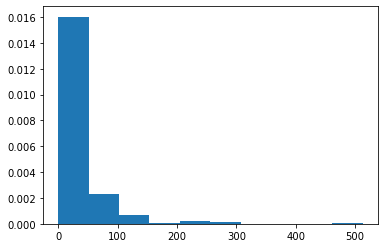

In [9]:
# Plot histogram of Fare to observe distribution. This feature will be used, due to complement with NumericTicket
plt.hist(x=training_data["Fare"], density=True)
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


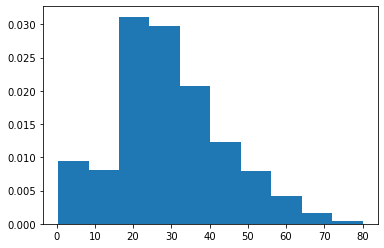

In [10]:
# Plot histogram of Age to observe distribution 
plt.hist(x=training_data["Age"], density=True)
plt.show()

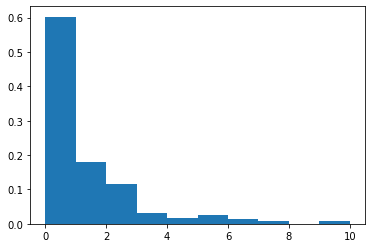

In [11]:
# Plot histogram of familiars to observe distribution. These columns means that someone is in group or alone.
familiars_data = training_data["SibSp"] + training_data["Parch"]
plt.hist(x=familiars_data, density=True)
plt.show()

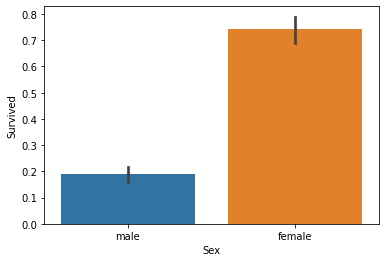

In [12]:
# Plot survived people (mean) taking into account Sex
sns.barplot(x=training_data["Sex"], y=training_data["Survived"])
plt.show()

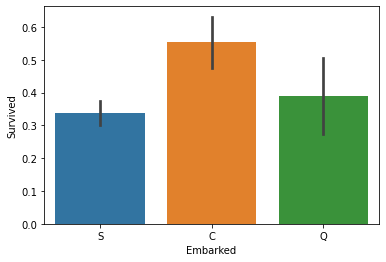

In [13]:
# Plot survived (mean) people taking into account Embarked
sns.barplot(x=training_data["Embarked"], y=training_data["Survived"])
plt.show()

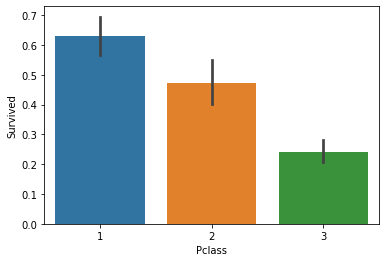

In [14]:
# Plot survived (mean) people taking into account Pclass
sns.barplot(x=training_data["Pclass"], y=training_data["Survived"])
plt.show()

# Prepare training and testing data

In [15]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
testing_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

def prepare_data(df, is_training=True):
    # Create a new feature based on SibSp and Parch. These columns are related with if a tripulant have a group, so sum them
    df["GroupSize"] = df["SibSp"] + df["Parch"] + 1

    # Ticket is kind of ID for username but sometimes a bunch of tripulants get the same Ticket number.
    # Create a feature taking into account if Ticket number is numeric or not
    df["TicketNumeric"] = df.apply(lambda row: 1 if row["Ticket"].isnumeric() else 0, axis=1)

    # Create a new Feature based on name prefix (Not considered, makes model overfits)
    # df["NamePrefix"] = df.apply(lambda row: row["Name"].split(",")[1].split(".")[0].strip(), axis=1)
    
    # Create a new Feature based on how many cabins a tripulant has
    df["CabinNumber"] = df.apply(lambda row: 0 if pd.isna(row["Cabin"]) else len(row["Cabin"].split(" ")), axis=1)

    # Handle Age NaN values as filling them with median
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    
    # Handle Fare NaN values on Testing set as filling them with median
    df["Fare"].fillna(df["Fare"].mean(), inplace=True)

    # Drop unused columns
    df.drop(["SibSp", "Parch", "PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

    # Drop NaN Embarked rows. I did it because there are only 2 rows
    df.dropna(subset=["Embarked"], inplace=True)
    
    # Label encoder to convert categorical data into numerical data
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    df_encoded["Pclass"] = label_encoder.fit_transform(df_encoded["Pclass"])
    df_encoded["Embarked"] = label_encoder.fit_transform(df_encoded["Embarked"])
    df_encoded["Sex"] = label_encoder.fit_transform(df_encoded["Sex"])
    
    # Standard Scaler
    scale = StandardScaler()
    df_encoded[["Age", "Fare"]] = scale.fit_transform(df_encoded[["Age", "Fare"]])
    
    return df_encoded

# Prepare training and testing data
training_data_encoded = prepare_data(training_data.copy())
testing_data_encoded = prepare_data(testing_data.copy())

In [18]:
training_data_encoded.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,GroupSize,TicketNumeric,CabinNumber
0,0,2,1,-0.590495,-0.500240,2,2,0,0
1,1,0,0,0.643971,0.788947,0,2,0,1
2,1,2,0,-0.281878,-0.486650,2,1,0,0
3,1,0,0,0.412509,0.422861,2,2,1,1
4,0,2,1,0.412509,-0.484133,2,1,1,0


In [19]:
testing_data_encoded.head()

,Pclass,Sex,Age,Fare,Embarked,GroupSize,TicketNumeric,CabinNumber
0,2,1,0.334993,-0.498407,1,1,1,0
1,2,0,1.325530,-0.513274,2,2,1,0
2,1,1,2.514175,-0.465088,1,1,1,0
3,2,1,-0.259330,-0.483466,2,1,1,0
4,2,0,-0.655545,-0.418471,2,3,1,0


# Split data

In [20]:
def split_data(df, is_training=True):
    if is_training:
        # Clean Survived column
        df["Survived"] = df["Survived"].astype(int)
        
        # Get X and Y
        feature_columns = df.columns[1:]
        X = df.loc[:, feature_columns].to_numpy()
        Y = df["Survived"].to_numpy()
    else:
        # Get X, Y is None
        feature_columns = df.columns
        X = df.loc[:, feature_columns].to_numpy()
        Y = None
    return X, Y

# Split data
X_train, Y_train = split_data(training_data_encoded)
X_test, _ = split_data(testing_data_encoded, is_training=False)

In [21]:
print(X_train.shape, X_test.shape, Y_train.shape)

(889, 8) (418, 8) (889,)


# Model
Try to test different models and choose the best one.

In [22]:
cross_valid_param = 20

## KNN

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

# Train and Cross Validation
knn_cross_valid = cross_val_score(knn_classifier, X_train, Y_train, cv=cross_valid_param)

# Print accuracy
print(f"KNN Cross Validation accuracy: {round(knn_cross_valid.mean() * 100, 2)}")

KNN Cross Validation accuracy: 78.86


In [24]:
# Fit model
knn_classifier.fit(X_train, Y_train)

# Predict output
knn_predicted = knn_classifier.predict(X_test).astype(int)
print(knn_predicted)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0
 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0
 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1
 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 1]


## Linear SVM

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svc_classifier = SVC(probability = True, C=1, gamma=0.1, kernel= "rbf")

# Train and Cross Validation
svc_cross_valid = cross_val_score(svc_classifier, X_train, Y_train, cv=cross_valid_param)

# Print accuracy
print(f"Linear SVM Cross Validation accuracy: {round(svc_cross_valid.mean() * 100, 2)}")

Linear SVM Cross Validation accuracy: 82.34


In [26]:
# Fit model
svc_classifier.fit(X_train, Y_train)

# Predict output
svc_predicted = svc_classifier.predict(X_test).astype(int)
print(svc_predicted)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [27]:
# Prepare submission
final_data = { "PassengerId": testing_data["PassengerId"], "Survived": knn_predicted }
final_df = pd.DataFrame(final_data)
final_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [28]:
# Save submission
final_df.to_csv('submission_knn.csv', index=False)